In [2]:
import torch
import pandas as pd
import numpy as np
from models.Zilpzalp import Zilpzalp
from models.Bulbul import Bulbul
from Datasets.static_dataset import SpectralDataset
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score

In [37]:
Zilpzalpfirst = 'checkpoint.feca6871-acb7-4549-b1a0-86d474777c3a.tar'
Zilpzalp60 = 'checkpoint.949aa7f2-22ee-4ad8-bc93-47ee89edd167.tar' # 60% in epoch 45
Zilpzalp98 = 'checkpoint.c15607ac-e194-45d1-803d-9d03ccc7db30.tar' # 98% in epoch 14 -> information leakage
Bulbul62 = 'checkpoint.86355c21-d360-4e03-8fbf-c1c37f7fd29f.tar' # Overfitted

In [38]:
df_train = pd.read_csv('storage/df_train_local.csv')
ds_train = SpectralDataset(df_train)
df_test = pd.read_csv('storage/df_test_local.csv')
ds_test = SpectralDataset(df_test)
codes = pd.read_csv('storage/label_codes.csv')

In [39]:
model = Bulbul(128, 216, 10)
model.load_state_dict(torch.load(Bulbul62)['state_dict'])

In [40]:
def predict(dataset, model):
    with torch.no_grad():
        model.eval()
        pred = []
        real = []
        for sample in dataset:
            p = model(torch.Tensor(sample[0]).unsqueeze(dim = 0) ** 0.17)
            pred.append(np.argmax(p.detach().numpy()))
            real.append(sample[1])
        return pred, real

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt



This takes long:

In [42]:
pred_train, real_train = predict(ds_train, model)   

In [43]:
pred_test, real_test = predict(ds_test, model)   

In [44]:
print('Test Acc: ', accuracy_score(real_test, pred_test))

Test Acc:  0.6228114057028514


Actual plotting:

In [45]:
cnf_matrix_train = confusion_matrix(real_train, pred_train)
cnf_matrix_test = confusion_matrix(real_test, pred_test)

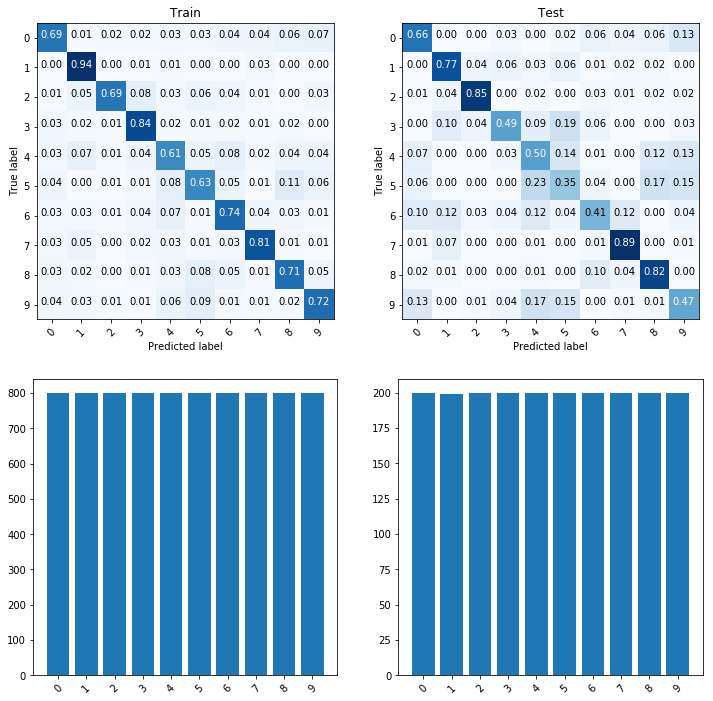

Train Acc:  0.7385326834145732 , Test Acc:  0.6228114057028514


In [46]:
plt.figure(figsize = (12, 12))
plt.title('Confusion Matrices and class distributions Train/Test')

plt.subplot(221)
plot_confusion_matrix(cnf_matrix_train, classes=list(range(10)), normalize=True,title='Train')

plt.subplot(222)
plot_confusion_matrix(cnf_matrix_test, classes=list(range(10)), normalize=True, title='Test')

plt.subplot(223)
unique, counts = np.unique(real_train, return_counts=True)
plt.bar(unique, counts)
plt.xticks(unique, rotation=45)

plt.subplot(224)
unique, counts = np.unique(real_test, return_counts=True)
plt.bar(unique, counts)
plt.xticks(unique, rotation=45)
plt.show()
print('Train Acc: ', accuracy_score(real_train, pred_train), ', Test Acc: ', accuracy_score(real_test, pred_test))

In [47]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.layer1.register_forward_hook(get_activation('Conv2d'))
data, _ = ds_train[0]
data = torch.Tensor(data)
data.unsqueeze_(0)
output = model(data)

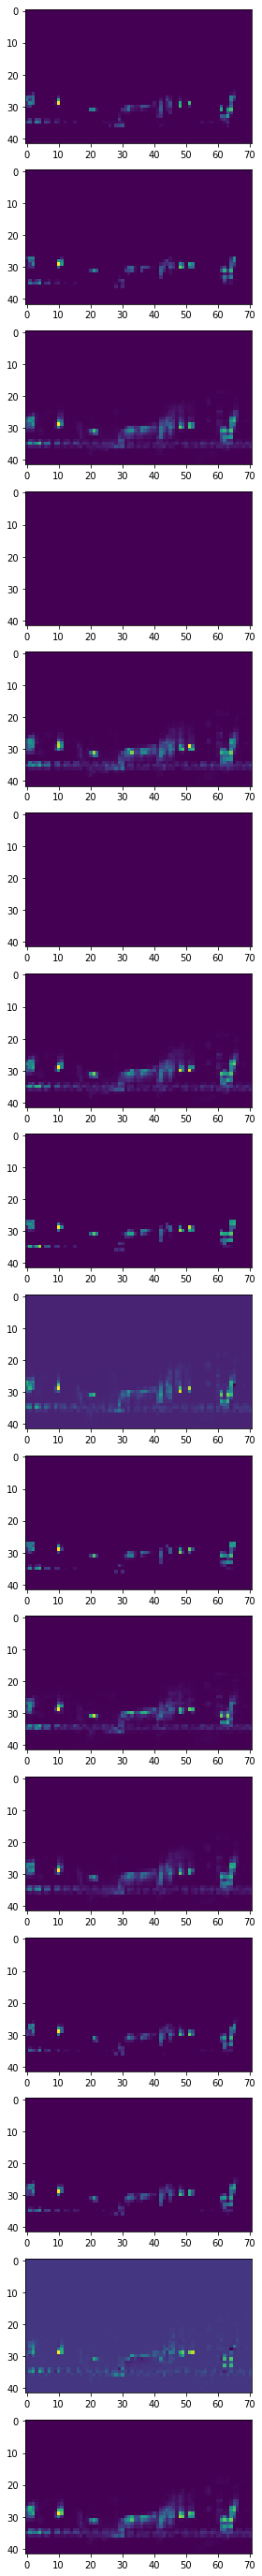

In [57]:
act = activation['Conv2d'].squeeze()
fig, axarr = plt.subplots(act.size(0), figsize=(50,50))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])

In [14]:
from torch.utils.data import DataLoader
import torch.nn.functional as F

dl_test = DataLoader(ds_test, 32)

In [15]:
def evaluate_model(model, test_loader, print_info=False):
        with torch.no_grad():
            model.eval()
            collect_results = []
            collect_target = []
            for batch in test_loader:
                X, y = batch
                X = X.float()
    
                y = y.detach().numpy()
                pred = model(X)
    
                collect_results.append(F.softmax(pred, dim=-1).detach().cpu().numpy())
                collect_target.append(y) 

            preds_proba = np.concatenate(collect_results)
            preds = preds_proba.argmax(axis=1)

            targets = np.concatenate(collect_target)

            #ll = log_loss(targets, preds_proba)
            acc = accuracy_score(targets, preds)
            if print_info:
                print("test log-loss: {}".format(ll))
                print("overall accuracy:  {}".format(acc))
                #print(classification_report(targets, preds))
            model.train()

            return acc

In [16]:
acc = evaluate_model(model, dl_test)

In [17]:
acc

0.6028543307086615

In [18]:
import pickle
def load_examples(df, cl, no):
    def unpickle(path):
        with open(path, 'rb') as f:
            slice_ = pickle.load(f)
        return slice_
    sel = df[df.label == cl].sample(n= no)
    paths = sel.path
    slices = []
    for path in paths:
        slices.append(unpickle(path))
    return slices

In [33]:
def plot_examples(df, cl = 10, no = 10):
    fig, ax = plt.subplots(cl, no,figsize=(20,12))
    
    for i in range(cl):
        ex = load_examples(df, i, no)
        for j, img in enumerate(ex):
            ax[i, j].imshow(np.log(img + 1e-10), cmap = 'Greys')
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
        ax[i, 0].set_ylabel(f'Class: {i}', rotation=90, size = 'large')
        
    plt.tight_layout()
    plt.show()

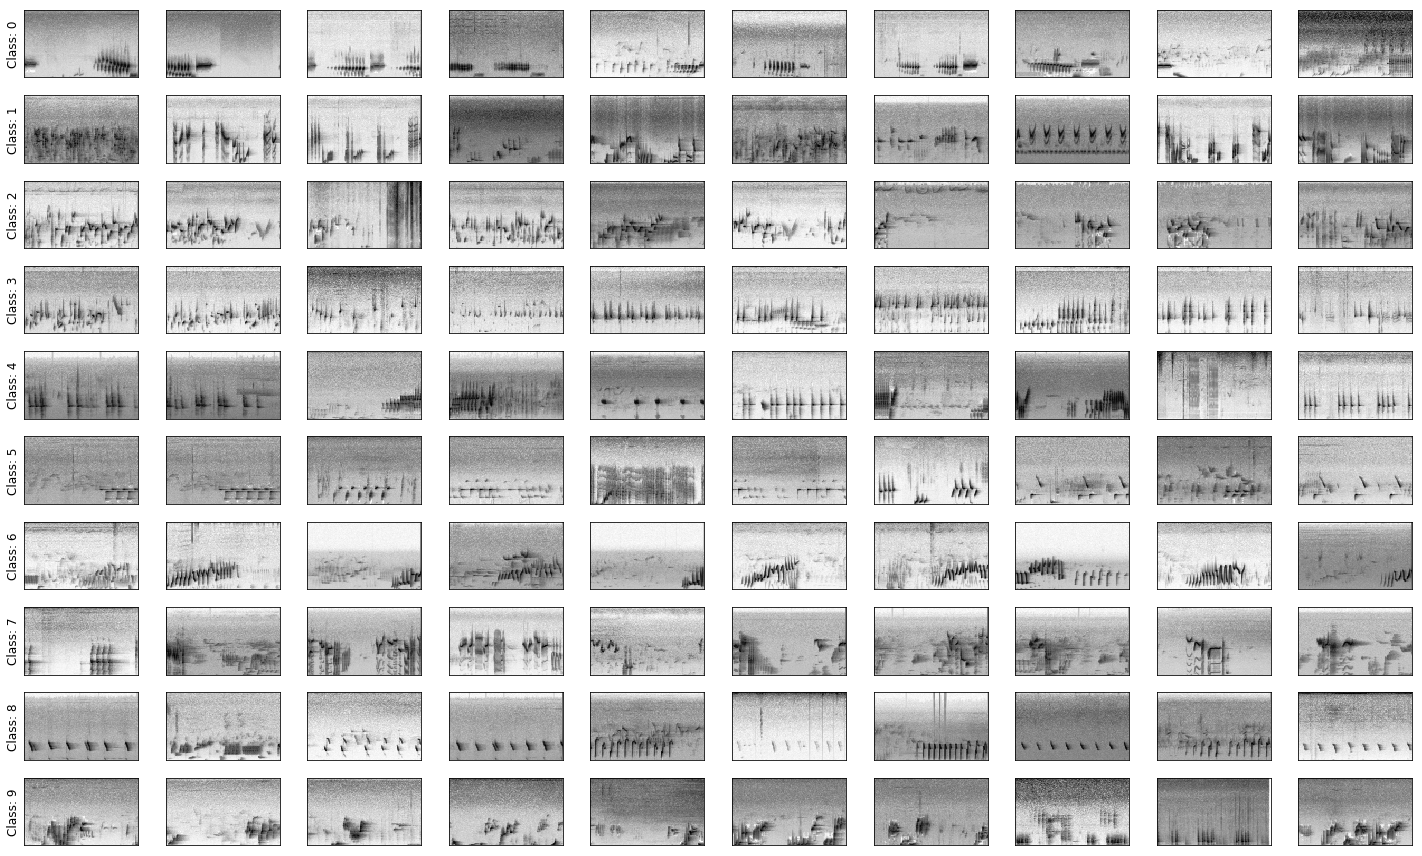

In [34]:
plot_examples(df_test)

In [21]:
codes

,Unnamed: 0,code
0,emberiza_citrinella,0
1,turdus_philomelos,1
2,sylvia_atricapilla,2
3,loxia_curvirostra,3
4,fringilla_coelebs,4
5,parus_major,5
6,phylloscopus_trochilus,6
7,turdus_merula,7
8,phylloscopus_collybita,8
9,erithacus_rubecula,9


In [38]:
from ipywidgets import interact, interactive, fixed, interact_manual
x = np.linspace(0, 10, 100)

def f(x, e):
    return x ** e

In [39]:

@interact(e=0.17)
def plot(e)
    y = f(x)
    plt.plot(x, y)

SyntaxError: invalid syntax (<ipython-input-39-bc038fd7b15c>, line 3)